In [371]:
# DERs
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

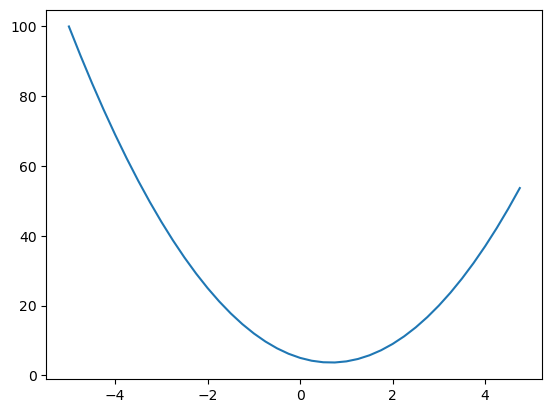

In [12]:
x = np.arange(-5,5,0.25)
y = f(x)
plt.plot(x,y)

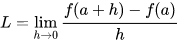

In [17]:
a = 2/3
h = 0.00001
(f(a+h) - f(a)) / h

3.0000002482211127e-05

In [18]:
#more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c 
print(d)

4.0


In [24]:
h = 0.00001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c 
c += h
d2 = a*b + c 

print("d1", d1 , "d2", d2)
print('slope', (d2-d1)/h)
#Derivative shows how change in one varible changes answer
# In NN how we tweak a weights to get better out put

d1 4.0 d2 4.00001
slope 0.9999999999621422


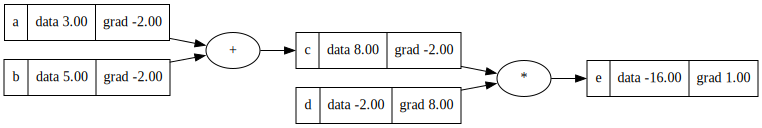

In [244]:
a = Value(3, label='a')
b = Value(5, label='b')
c = a+b; c.label='c'
d = Value(-2, label='d')
e = c*d; e.label ='e'

e.grad=1
e._backward()
c._backward()
draw_dot(e)

In [365]:
##from memory simple chain

class Value:

    def __init__(self, data, _children=(), _op = '', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None 
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, _op={self._op})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data+other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self*-1

    def __sub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self*other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, (self, other), '*')

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward

        return out 


    def __rmul__(self, other):
        return self*other
    
    def __truediv__(self, other):
        return self * (other**-1)



    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
           self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    


    ###################
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [357]:
from graphviz import Digraph

def trace(root):
    # builds a set od all nodes and edges in a graph

    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir' : 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it 
        dot.node(name = uid, label = "{ %s | data %.2f | grad %.2f} " % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value in the graph, create a rectangular ('record') node for it

            dot.node(name = uid+n._op, label = n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to the op of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot
     

In [367]:
# inputs x1,x1
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1+x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'


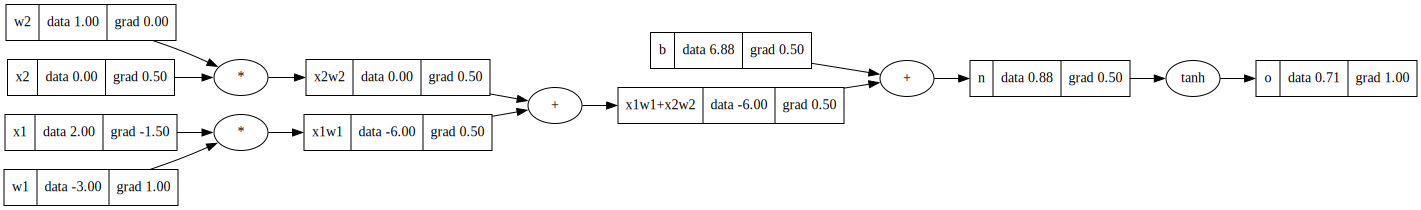

In [368]:
o.backward()
draw_dot(o)

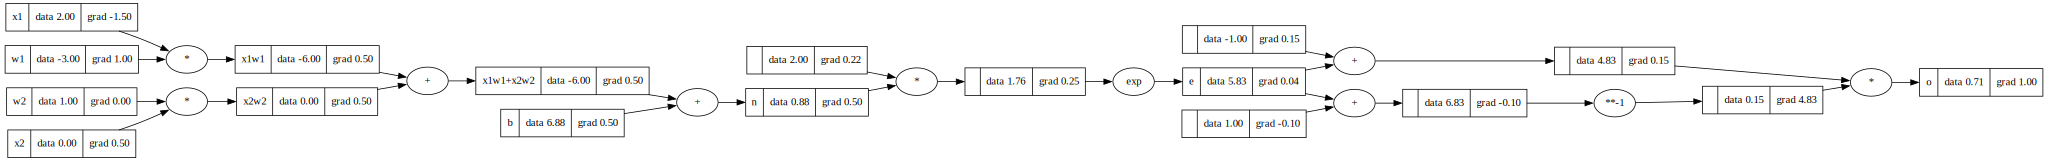

In [369]:
# inputs x1,x1
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1+x2w2'
n = x1w1x2w2 + b; n.label='n'
#============
e = (2*n).exp();e.label='e'
o = (e-1)/(e+1); o.label='o'
#============
o.backward()
draw_dot(o)

In [360]:
#nice visual of how topoligical sort works
# topo = []
# visited = set()

# def build_topo(v, level=0):
#     padding = "------" * level
#     print(padding + "Building for: ", v.label)
#     if v not in visited:
#         visited.add(v)
#         print(padding + "Added to visited: ", v.label)
#         print(padding + "Current visited set: ", set(n.label for n in visited))
#         for child in v._prev:
#             print(padding + f"Exploring children of {v.label}. Now looking at {child.label}.")
#             build_topo(child, level + 1)
#         topo.append(v)
#         print(padding + f"Added to topo: {v.label}")
#         print(padding + "Current topo list: ", [n.label for n in topo])

# build_topo(o)
# print("Final topo list: ", [n.label for n in topo])


In [366]:
a = Value(2.0)
b = Value(4.0)
a/b
a-b 

Value(data=-2.0, _op=+)

In [427]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,-1))

    def __call__(self, x):
        #w*x+b
        act = sum([wi*xi for wi, xi in zip(self.w, x)], self.b)
        out = act.tanh()
        return out 
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return(x)
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [428]:
x = [2.0, 3.0, -1]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.9342243624171386, _op=tanh)

In [488]:
nn.parameters()

[Value(data=-0.3797344292190856, _op=),
 Value(data=0.806908614056133, _op=),
 Value(data=0.09434854690684547, _op=),
 Value(data=-1.0, _op=),
 Value(data=-0.33823401258611363, _op=),
 Value(data=-0.7362578110366051, _op=),
 Value(data=-0.14579824360077187, _op=),
 Value(data=-1.0, _op=),
 Value(data=0.3639682809490299, _op=),
 Value(data=0.15888184807954175, _op=),
 Value(data=-0.7271089077135617, _op=),
 Value(data=-1.0, _op=),
 Value(data=0.624773478505537, _op=),
 Value(data=0.40349185495491713, _op=),
 Value(data=0.35861741717323814, _op=),
 Value(data=-1.0, _op=),
 Value(data=0.9010758105117338, _op=),
 Value(data=0.7945911377304296, _op=),
 Value(data=-0.058815950916538684, _op=),
 Value(data=0.15479097949365817, _op=),
 Value(data=-1.0, _op=),
 Value(data=-0.18969849567095487, _op=),
 Value(data=-0.5786136749037811, _op=),
 Value(data=-0.5261286730322003, _op=),
 Value(data=-0.010620738812465946, _op=),
 Value(data=-1.0, _op=),
 Value(data=0.16236943913521773, _op=),
 Value(dat

In [516]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

In [517]:
NN = MLP(3, [4,4,1])

0.08954518704614794


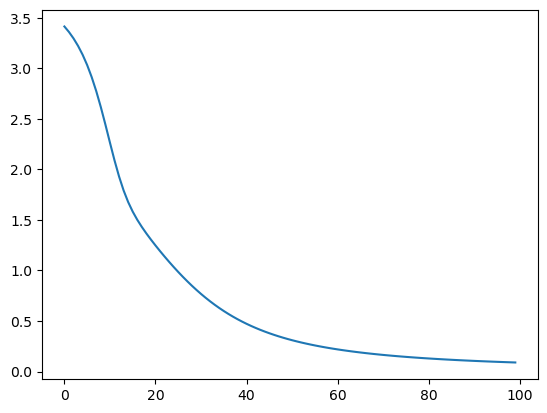

In [518]:
losses = []
for k in range(100):
    ypred = [NN(x) for x in xs]
    loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])
    losses.append(loss.data)


    for p in NN.parameters():
        p.grad = 0.0
        
    loss.backward()

    for p in NN.parameters():
        p.data += -0.01 * p.grad
    #print(k, loss.data)

plt.plot(np.arange(100), losses)
print(losses[-1])

In [503]:
NN = MLP(3, [4,4,1])

for _ in range(30):
    ypred = [NN(x) for x in xs]
    loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])
    print(loss.data)
    loss.backward()

    for ls in NN.layers:
        for ns in ls.neurons:
            for ws in ns.w:
                ws.data += -0.01 * ws.grad
            ns.b.data += -0.01 * ns.b.grad

2.4260697373449887
2.3497419260320225
2.2439571380573335
2.1561226406823693
2.096696630194178
2.046340890339121
1.9810095580156704
1.8872490102233204
1.7681328197254835
1.6418939408163458
1.5231764103925372
1.3921685677722064
1.2039958524967576
0.9614180678111067
0.7119370342156386
0.43937869376579164
0.19841888689818737
0.08180214857518943
0.04159059158857706
0.026063974849314137
0.018591813892946854
0.014384571997490589
0.011710921597090546
0.009832317844636855
0.008405985851403286
0.007262985766815356
0.006314606921381278
0.0055105125269881575
0.004819470202885717
0.004220323454536181
